In [139]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm


# TO CHANGE
# absolute path to ACCAL/ACCAL folder
appPath = Path(r"D:\Stage\ACCAL\ACCAL")
sys.path.append(str(appPath))

#Kernel module
import numpy as np
import modules.features.kernel
import modules.features.selection
import scipy.sparse


# Path to data 
dataFolderPath = Path(r"D:\Stage\ACCAL\data\dataTest1","temp","processedImages")



In [25]:
%load_ext autoreload
%autoreload 2


import sys
from pathlib import Path
import matplotlib.pyplot as plt

appPath = Path(r"D:\Stage\ACCAL\ACCAL")
sys.path.append(str(appPath))

# Path to data 
data1 = sorted(list(Path(r"D:\Stage\ACCAL\data\dataTest1","temp","croppedImages").glob("*.png")))
data2 = sorted(list(Path(r"D:\Stage\ACCAL\data\dataTest2","temp","croppedImages").glob("*.png")))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exemple image base de données

In [51]:
img1=plt.imread(data1[6])
img2=plt.imread(data1[8])
img3=plt.imread(data1[17])
img4=plt.imread(data1[50])

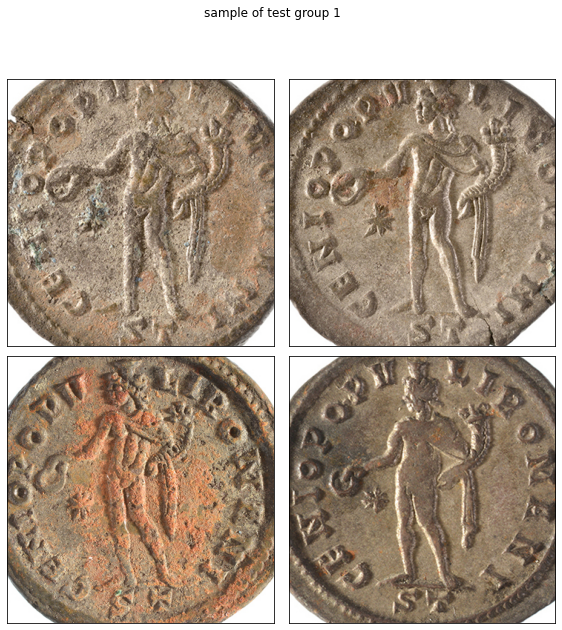

In [122]:

fig,axes = plt.subplots(2,2,figsize=(10,10))
for ax in axes.ravel():
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax1,ax2,ax3,ax4 = axes.ravel()
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)

fig.subplots_adjust(wspace=0.02, hspace=0.04)

fig.suptitle("sample of test group 1")
fig.savefig("sample of test group1",bbox_inches='tight',dpi=300)
plt.show()


In [ ]:

import cv2
#gray transformation
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


imgTV = skimage.restoration.denoise_tv_chambolle(gray,0.1)

ax2.set_title("After TV denoise")
ax2.imshow(imgTV,cmap='gray')
plt.show()

## Préprocessing 

In [124]:

import cv2
import skimage
#gray transformation
gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)


imgTV = skimage.restoration.denoise_tv_chambolle(gray,0.1)

imgCtr = skimage.exposure.equalize_adapthist(imgTV, clip_limit=0.01)

imgTV2 = skimage.restoration.denoise_tv_chambolle(imgCtr,0.1)


imgL = skimage.filters.sobel(imgTV2)


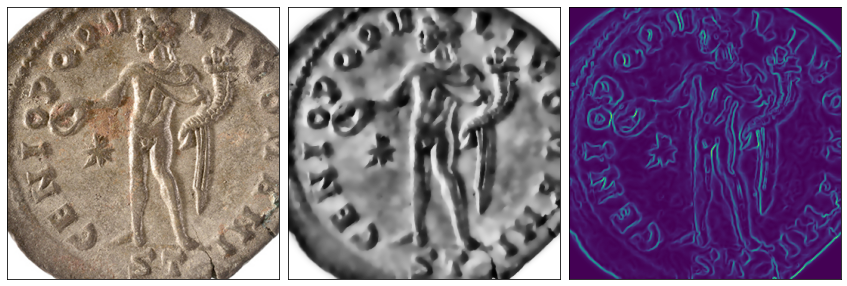

In [130]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

for ax in axes.ravel():
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax1,ax2,ax3= axes.ravel()
fig.subplots_adjust(wspace=0.02, hspace=0)

ax1.imshow(img2)
ax2.imshow(imgTV2,cmap='gray')
ax3.imshow(imgL)

fig.savefig("preprocessing example",bbox_inches='tight',dpi=300)
plt.show()


## Selection des PI 


In [141]:
import modules.features.kernel

K = modules.features.kernel.getK(l=4.0,absAppPath=appPath ,pixelSide=360)

def getKwColumn(K:scipy.sparse.csr_matrix,imgVec:np.ndarray,column:int)->scipy.sparse.csr_matrix:
    KD = K[:,column].multiply(imgVec.reshape(-1,1))
    return K.transpose().dot(KD)




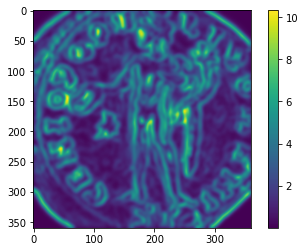

In [142]:
imgVec = imgL.ravel().reshape(-1,1)
K2 = K.power(2)
T = K2.transpose()
traceVec = T.dot(imgVec.reshape(-1,1))
plt.imshow(traceVec.reshape(360,360))
plt.colorbar()



In [147]:
nbFeatures = 150


featuresList = []
varVec = 0
psi = 0

varVec1 = 0

varVec10 = 0

varVec100 = 0

for i in range(nbFeatures):
    if i == 0 :
        ## First feature
        idxMax = np.argmax(imgVec)
        featuresList.append(idxMax)  
        
        col = getKwColumn(K,imgVec,idxMax)
        psi = scipy.sparse.csr_matrix(col)     
        
        varXsi = traceVec[featuresList].ravel()
        invVarXsi = 1/varXsi
        invVarXsiDiag = scipy.sparse.diags(invVarXsi)  
        
        varVec = scipy.sparse.csc_matrix(traceVec) - psi.power(2).dot(invVarXsi.reshape(-1,1)).reshape(-1,1)
        
    else: 
        
        idxMax = np.argmax(varVec)
        featuresList.append(idxMax)
         
        col = getKwColumn(K,imgVec,idxMax)
        psi = scipy.sparse.hstack([psi,col])
            
        varXsi = traceVec[featuresList].ravel()
        invVarXsi = 1/varXsi
        #invVarXsiDiag = scipy.sparse.diags(invVarXsi)
    
        varVec = scipy.sparse.csc_matrix(traceVec) - psi.power(2).dot(invVarXsi.reshape(-1,1)).reshape(-1,1)
        
        if i==1:
            varVec1 = np.copy(varVec)
        if i == 10:
            varVec10 = np.copy(varVec)
        if i == 100:
            varVec100 = np.copy(varVec)

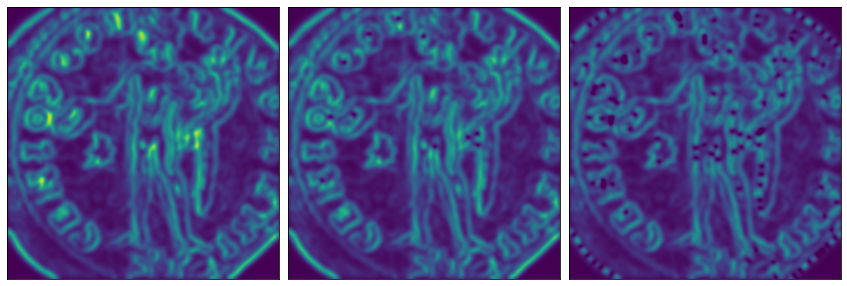

In [149]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

for ax in axes.ravel():
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax1,ax2,ax3= axes.ravel()
fig.subplots_adjust(wspace=0.02, hspace=0)

ax1.imshow(traceVec.reshape(360,360),vmin=0,vmax=11)
ax2.imshow(varVec10.reshape(360,360),vmin=0,vmax=11)
ax3.imshow(varVec100.reshape(360,360),vmin=0,vmax=11)

fig.savefig("varVec",bbox_inches='tight',dpi=300)


## Filter les correspondances